# Bank Customer Churn Analysis and Modeling Notebook 

 ### 1. 🧹 Data Foundation & Feature Engineering

🏗️ Project Setup & Data Ingestion

In [15]:
# Import necessary libraries (Ensuring all are available)
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown


In [16]:
import pandas as pd
import os

# Define the data folder
DATA_DIR = "/workspaces/Bank-Customer-Data-Prep/data"

# Paths to files
xlsx_path = os.path.join(DATA_DIR, "Bank_Churn_Messy.xlsx")
csv_path  = os.path.join(DATA_DIR, "Bank_Churn.csv")
csv_alt   = os.path.join(DATA_DIR, "Bank_Churn_Modelling.csv")

# Load data
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
elif os.path.exists(csv_alt):
    df = pd.read_csv(csv_alt)
elif os.path.exists(xlsx_path):
    try:
        cust = pd.read_excel(xlsx_path, sheet_name="Customer_Info")
        acct = pd.read_excel(xlsx_path, sheet_name="Account_Info")
        df = pd.merge(cust, acct, on="CustomerId", how="left")
    except:
        df = pd.read_excel(xlsx_path)
else:
    raise FileNotFoundError(f"No data file found in {DATA_DIR}")


In [17]:
# 2. Feature Engineering (Creates the necessary columns)
if 'NumOfProducts' in df.columns and 'Tenure' in df.columns:
    df['ProductPerYear'] = np.where(df['Tenure'] == 0, df['NumOfProducts'], df['NumOfProducts'] / df['Tenure'])
else:
    df['ProductPerYear'] = 0.0

if 'Balance' in df.columns and 'EstimatedSalary' in df.columns:
    df['balance_to_income'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['income_v_product'] = df['EstimatedSalary'] / (df['NumOfProducts'] + 1)
else:
    df['balance_to_income'] = 0.0
    df['income_v_product'] = 0.0

    # Basic cleaning (Necessary for Gender_num)
df.columns = df.columns.str.strip().str.replace(" ", "_")
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
    df['Gender_num'] = np.where(df['Gender'] == 'Female', 1, 0)
else:
    df['Gender_num'] = 0

In [18]:
# --- Ensure Geo columns are added and ready for scaling ---

# Define main features (numeric + engineered)
features = [
    'CreditScore','Gender_num','Age','Tenure','Balance','NumOfProducts',
    'HasCrCard','IsActiveMember','EstimatedSalary','ProductPerYear',
    'balance_to_income','income_v_product'
]

# Keep only columns that exist in df
features = [c for c in features if c in df.columns]

# One-hot encode Geography for France, Germany, Spain
for c in ['France','Germany','Spain']:
    if 'Geography' in df.columns:
        df[c] = (df['Geography'].astype(str).str.strip().str.title() == c).astype(int)
    else:
        df[c] = 0

display(df[features + ['France','Germany','Spain']].head())


CreditScore  Gender_num  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619           1   42       2       0.00              1          1   
1          608           1   41       1   83807.86              1          0   
2          502           1   42       8  159660.80              3          1   
3          699           1   39       1       0.00              2          0   
4          850           1   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  ProductPerYear  balance_to_income  \
0               1        101348.88           0.500           0.000000   
1               1        112542.58           1.000           0.744670   
2               0        113931.57           0.375           1.401362   
3               0         93826.63           2.000           0.000000   
4               1         79084.10           0.500           1.587035   

   income_v_product  France  Germany  Spain  
0      50674.440000       1        0      0  
1      56271.290000       0        0      1  
2      28482.892500       1        0      0  
3      31275.543333       1        0      0  
4      39542.050000       0        0      1

In [19]:
# --- Scale Features (Numeric + Geo) ---

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Combine numeric/engineered features + Geo one-hots
cols_to_scale = features + ['France', 'Germany', 'Spain']

# Initialize scaler
scaler = StandardScaler()

# Fit & transform
df_scaled_features = pd.DataFrame(
    scaler.fit_transform(df[cols_to_scale]),
    columns=cols_to_scale,
    index=df.index
)

# Optional: combine with target and Geography for reference
df_scaled = df_scaled_features.copy()
df_scaled['Exited'] = df['Exited'] if 'Exited' in df.columns else 0
df_scaled['Geography'] = df['Geography'] if 'Geography' in df.columns else 'Unknown'

display(df_scaled.head())


CreditScore  Gender_num       Age    Tenure   Balance  NumOfProducts  \
0    -0.326221    1.095988  0.293517 -1.041760 -1.225848      -0.911583   
1    -0.440036    1.095988  0.198164 -1.387538  0.117350      -0.911583   
2    -1.536794    1.095988  0.293517  1.032908  1.333053       2.527057   
3     0.501521    1.095988  0.007457 -1.387538 -1.225848       0.807737   
4     2.063884    1.095988  0.388871 -1.041760  0.785728      -0.911583   

   HasCrCard  IsActiveMember  EstimatedSalary  ProductPerYear  \
0   0.646092        0.970243         0.021886       -0.016781   
1  -1.547768        0.970243         0.216534        0.967674   
2   0.646092       -1.030670         0.240687       -0.262894   
3  -1.547768       -1.030670        -0.108918        2.936584   
4   0.646092        0.970243        -0.365276       -0.016781   

   balance_to_income  income_v_product    France   Germany     Spain  Exited  \
0          -0.037882          0.356019  0.997204 -0.578736 -0.573809       1   
1          -0.030439          0.572694 -1.002804 -0.578736  1.742740       0   
2          -0.023876         -0.503099  0.997204 -0.578736 -0.573809       1   
3          -0.037882         -0.394985  0.997204 -0.578736 -0.573809       0   
4          -0.022020         -0.074958 -1.002804 -0.578736  1.742740       0   

  Geography  
0    France  
1     Spain  
2    France  
3    France  
4     Spain

In [20]:
# --- 3. Define Features and One-Hot Encode Geography ---
features = [
    'CreditScore','Gender_num','Age','Tenure','Balance','NumOfProducts',
    'HasCrCard','IsActiveMember','EstimatedSalary','ProductPerYear',
    'balance_to_income','income_v_product'
]
features = [c for c in features if c in df.columns]

df_prep = df.copy()

# One-hot encode Geography
for c in ['France','Germany','Spain']:
    if 'Geography' in df_prep.columns:
        df_prep[c] = (df_prep['Geography'].astype(str).str.strip().str.title() == c).astype(int)
    else:
        df_prep[c] = 0

# Columns to scale (numeric features + country dummies)
cols_to_scale = features + [c for c in ['France','Germany','Spain'] if c in df_prep.columns]

In [21]:
# --- 4. Scale the Data ---
scaler_cluster_geo = StandardScaler()
df_scaled_features = pd.DataFrame(
    scaler_cluster_geo.fit_transform(df_prep[cols_to_scale]),
    columns=cols_to_scale,
    index=df_prep.index
)

# Combine scaled features with target & Geography
df_scaled = df_scaled_features.copy()
df_scaled['Exited'] = df_prep['Exited']
df_scaled['Geography'] = df_prep['Geography']

In [22]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- 5. Unified Prediction Logic (12-Feature Model Fix) ---
model_path = "/workspaces/Bank-Customer-Data-Prep/churn_model.pkl"
scaler_path = "/workspaces/Bank-Customer-Data-Prep/scaler.pkl"

with open(model_path, "rb") as f:
    model = pickle.load(f)
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

# The EXACT 12 features both the scaler AND model expect
required_features = [
    'CreditScore', 'Gender_num', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'ProductPerYear',
    'balance_to_income', 'income_v_product'
]

def get_predictions(input_df: pd.DataFrame) -> pd.Series:
    df_work = input_df.copy()
    
    # 1. Handle Gender_num (if Gender string is provided)
    if 'Gender_num' not in df_work.columns and 'Gender' in df_work.columns:
        df_work['Gender_num'] = np.where(df_work['Gender'].astype(str).str.title() == 'Female', 1, 0)

    # 2. Handle Engineered Ratios
    if 'ProductPerYear' not in df_work.columns:
        df_work['ProductPerYear'] = df_work['NumOfProducts'] / (df_work['Tenure'] + 0.1)
    if 'balance_to_income' not in df_work.columns:
        df_work['balance_to_income'] = df_work['Balance'] / (df_work['EstimatedSalary'] + 1)
    if 'income_v_product' not in df_work.columns:
        df_work['income_v_product'] = df_work['EstimatedSalary'] / (df_work['NumOfProducts'] + 1)

    # 3. Ensure all 12 required columns exist
    for col in required_features:
        if col not in df_work.columns:
            df_work[col] = 0

    # 4. Filter and Order to exactly 12 features
    X_ordered = df_work[required_features].copy()

    # 5. Scale the 12 features
    X_scaled = scaler.transform(X_ordered.values)

    # 6. Predict Probability (Passing exactly 12 features)
    probs = model.predict_proba(X_scaled)[:, 1]
    
    return pd.Series(probs, index=df_work.index, name="Churn Probability")

print("✅ Final 12-Feature Prediction Function Loaded.")

✅ Final 12-Feature Prediction Function Loaded.


In [23]:
# --- 6. Test Prediction on Single Row ---
sim_customer = pd.DataFrame([{
    'CreditScore': 650,
    'Gender': 'Female', 
    'Age': 45,
    'Tenure': 3,
    'Balance': 50000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 60000,
    'Geography': 'France' 
}])

# Calculate probability
sim_customer['Churn Probability'] = get_predictions(sim_customer)

display(Markdown("### 🎯 Single Customer Prediction Result"))
display(sim_customer[['Geography', 'Age', 'Balance', 'Churn Probability']].style.format({
    'Churn Probability': '{:.2%}',
    'Balance': '${:,.2f}'
}))

### 🎯 Single Customer Prediction Result

In [24]:
# --- 7. Test Prediction on Batch Sample ---
# Grab first 5 rows of your existing dataframe
sample_test = df.iloc[:5].copy()

# Apply the function
sample_probs = get_predictions(sample_test)

# Join results for a final view
batch_results = pd.concat([
    sample_test[['Geography', 'Age', 'Balance']], 
    sample_probs
], axis=1)

display(Markdown("### 📊 Batch Prediction Results (First 5 Rows)"))
display(batch_results.style.format({
    'Churn Probability': '{:.2%}', 
    'Balance': '${:,.2f}'
}))

### 📊 Batch Prediction Results (First 5 Rows)

In [25]:
# 5. Combine Scaled Features with Target and Categorical Columns
df_scaled = df_scaled_features.copy()
df_scaled['Exited'] = df_prep['Exited']
df_scaled['Geography'] = df_prep['Geography']

display(Markdown("### ✅ All Data Prep Complete. `df_scaled` is Ready for Clustering."))
display(df_scaled.head())

### ✅ All Data Prep Complete. `df_scaled` is Ready for Clustering.

CreditScore  Gender_num       Age    Tenure   Balance  NumOfProducts  \
0    -0.326221    1.095988  0.293517 -1.041760 -1.225848      -0.911583   
1    -0.440036    1.095988  0.198164 -1.387538  0.117350      -0.911583   
2    -1.536794    1.095988  0.293517  1.032908  1.333053       2.527057   
3     0.501521    1.095988  0.007457 -1.387538 -1.225848       0.807737   
4     2.063884    1.095988  0.388871 -1.041760  0.785728      -0.911583   

   HasCrCard  IsActiveMember  EstimatedSalary  ProductPerYear  \
0   0.646092        0.970243         0.021886       -0.016781   
1  -1.547768        0.970243         0.216534        0.967674   
2   0.646092       -1.030670         0.240687       -0.262894   
3  -1.547768       -1.030670        -0.108918        2.936584   
4   0.646092        0.970243        -0.365276       -0.016781   

   balance_to_income  income_v_product    France   Germany     Spain  Exited  \
0          -0.037882          0.356019  0.997204 -0.578736 -0.573809       1   
1          -0.030439          0.572694 -1.002804 -0.578736  1.742740       0   
2          -0.023876         -0.503099  0.997204 -0.578736 -0.573809       1   
3          -0.037882         -0.394985  0.997204 -0.578736 -0.573809       0   
4          -0.022020         -0.074958 -1.002804 -0.578736  1.742740       0   

  Geography  
0    France  
1     Spain  
2    France  
3    France  
4     Spain

🧼 Deep Data Cleaning & Standardization

In [26]:
# --- Cell 3: 🧹 Duplicates, Missing Values, and Type Cleaning ---

# 1. Drop duplicates
dups = df.duplicated().sum()
display(Markdown(f"**Exact duplicate rows found:** {dups}"))
if dups > 0:
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    display(Markdown("Duplicates removed."))


**Exact duplicate rows found:** 0

In [27]:
# 2. Function to convert currency-like columns robustly
def to_numeric_currency(df_local, col):
    if col in df_local.columns:
        # remove currency symbols, commas, and coerce to numeric
        df_local[col] = (
            df_local[col]
            .astype(str)
            .str.replace(r'[^\d\.\-]', '', regex=True)
            .replace('', np.nan)
        )
        df_local[col] = pd.to_numeric(df_local[col], errors='coerce')
    return df_local

df = to_numeric_currency(df, 'Balance')
df = to_numeric_currency(df, 'EstimatedSalary')

In [28]:
# 3. Convert Binary features (Yes/No to 1/0)
if 'HasCrCard' in df.columns:
    df['HasCrCard'] = df['HasCrCard'].replace({'Yes':1,'No':0, 'yes':1, 'no':0}).astype('Int64')
if 'IsActiveMember' in df.columns:
    df['IsActiveMember'] = df['IsActiveMember'].replace({'Yes':1,'No':0, 'yes':1, 'no':0}).astype('Int64')


In [29]:
# 4. Clean Geography and Gender labels, then encode Gender
if 'Geography' in df.columns:
    df['Geography'] = df['Geography'].astype(str).str.strip().str.title()
    # Unify country labels
    df['Geography'] = df['Geography'].replace({
        'Fra':'France','Fr':'France','French':'France','FraNce':'France',
        'Spain':'Spain','Sp':'Spain','Germany':'Germany','Ger':'Germany','GerM':'Germany'
    })

if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
    df['Gender_num'] = np.where(df['Gender'] == 'Female', 1, 0)
else:
    df['Gender_num'] = 0


In [30]:
# 5. Handle missing values
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == object or df[col].dtype.name == 'category':
            df[col] = df[col].fillna("MISSING")
        else:
            # numeric: fill NaNs with median
            med = df[col].median()
            df[col] = df[col].fillna(med)

display(Markdown("**Cleaned Data Snapshot & Types**"))
display(df[['Balance','EstimatedSalary','Geography','Gender_num']].head())
display(df.dtypes)
display(Markdown(f"**Final Data Shape:** {df.shape}"))

**Cleaned Data Snapshot & Types**

Balance  EstimatedSalary Geography  Gender_num
0       0.00        101348.88    France           1
1   83807.86        112542.58     Spain           1
2  159660.80        113931.57    France           1
3       0.00         93826.63    France           1
4  125510.82         79084.10     Spain           1

CustomerId             int64
Surname               object
CreditScore            int64
Geography             object
Gender                object
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              Int64
IsActiveMember         Int64
EstimatedSalary      float64
Exited                 int64
ProductPerYear       float64
balance_to_income    float64
income_v_product     float64
Gender_num             int64
France                 int64
Germany                int64
Spain                  int64
dtype: object

**Final Data Shape:** (10000, 20)

 🛠️ Engineering Predictive Ratios

In [31]:
# --- Cell 4: ⚙️ Feature Engineering ---
# ProductPerYear: avoid division by zero
if 'NumOfProducts' in df.columns and 'Tenure' in df.columns:
    df['ProductPerYear'] = np.where(df['Tenure'] == 0, df['NumOfProducts'], df['NumOfProducts'] / df['Tenure'])
else:
    df['ProductPerYear'] = 0.0



In [32]:
# Balance to Income Ratio and Income vs Product
if 'Balance' in df.columns and 'EstimatedSalary' in df.columns:
    df['balance_to_income'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['income_v_product'] = df['EstimatedSalary'] / (df['NumOfProducts'] + 1)
else:
    df['balance_to_income'] = 0.0
    df['income_v_product'] = 0.0

display(df[['ProductPerYear','balance_to_income','income_v_product']].head())

ProductPerYear  balance_to_income  income_v_product
0           0.500           0.000000      50674.440000
1           1.000           0.744670      56271.290000
2           0.375           1.401362      28482.892500
3           2.000           0.000000      31275.543333
4           0.500           1.587035      39542.050000

### 2. 🔍 Exploratory Data Analysis (EDA) & Insights

CustomerId   CreditScore           Age        Tenure        Balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
count   10000.000000    10000.0         10000.0     10000.000000   
mean        1.530200     0.7055          0.5151    100090.239881   
std         0.581654    0.45584        0.499797     57510.492818   
min         1.000000        0.0             0.0        11.580000   
25%         1.000000        0.0             0.0     51002.110000   
50%         1.000000        1.0             1.0    100193.915000   
75%         2.000000        1.0             1.0    149388.247500   
max         4.000000        1.0             1.0    199992.480000   

             Exited  ProductPerYear  balance_to_income  income_v_product  \
count  10000.000000    10000.000000       10000.000000      10000.000000   
mean       0.203700        0.508523           3.790150      41478.250689   
std        0.402769        0.507921         100.055758      25831.889710   
min        0.000000        0.100000           0.000000          5.790000   
25%        0.000000        0.200000           0.000000      19854.190000   
50%        0.000000        0.333333           0.746998      39620.788333   
75%        0.000000        0.666667           1.514002      59687.742500   
max        1.000000        4.000000        9770.883148      99985.370000   

         Gender_num        France       Germany         Spain  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       0.454300      0.501400      0.250900      0.247700  
std        0.497932      0.500023      0.433553      0.431698  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      1.000000      0.000000      0.000000  
75%        1.000000      1.000000      1.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000

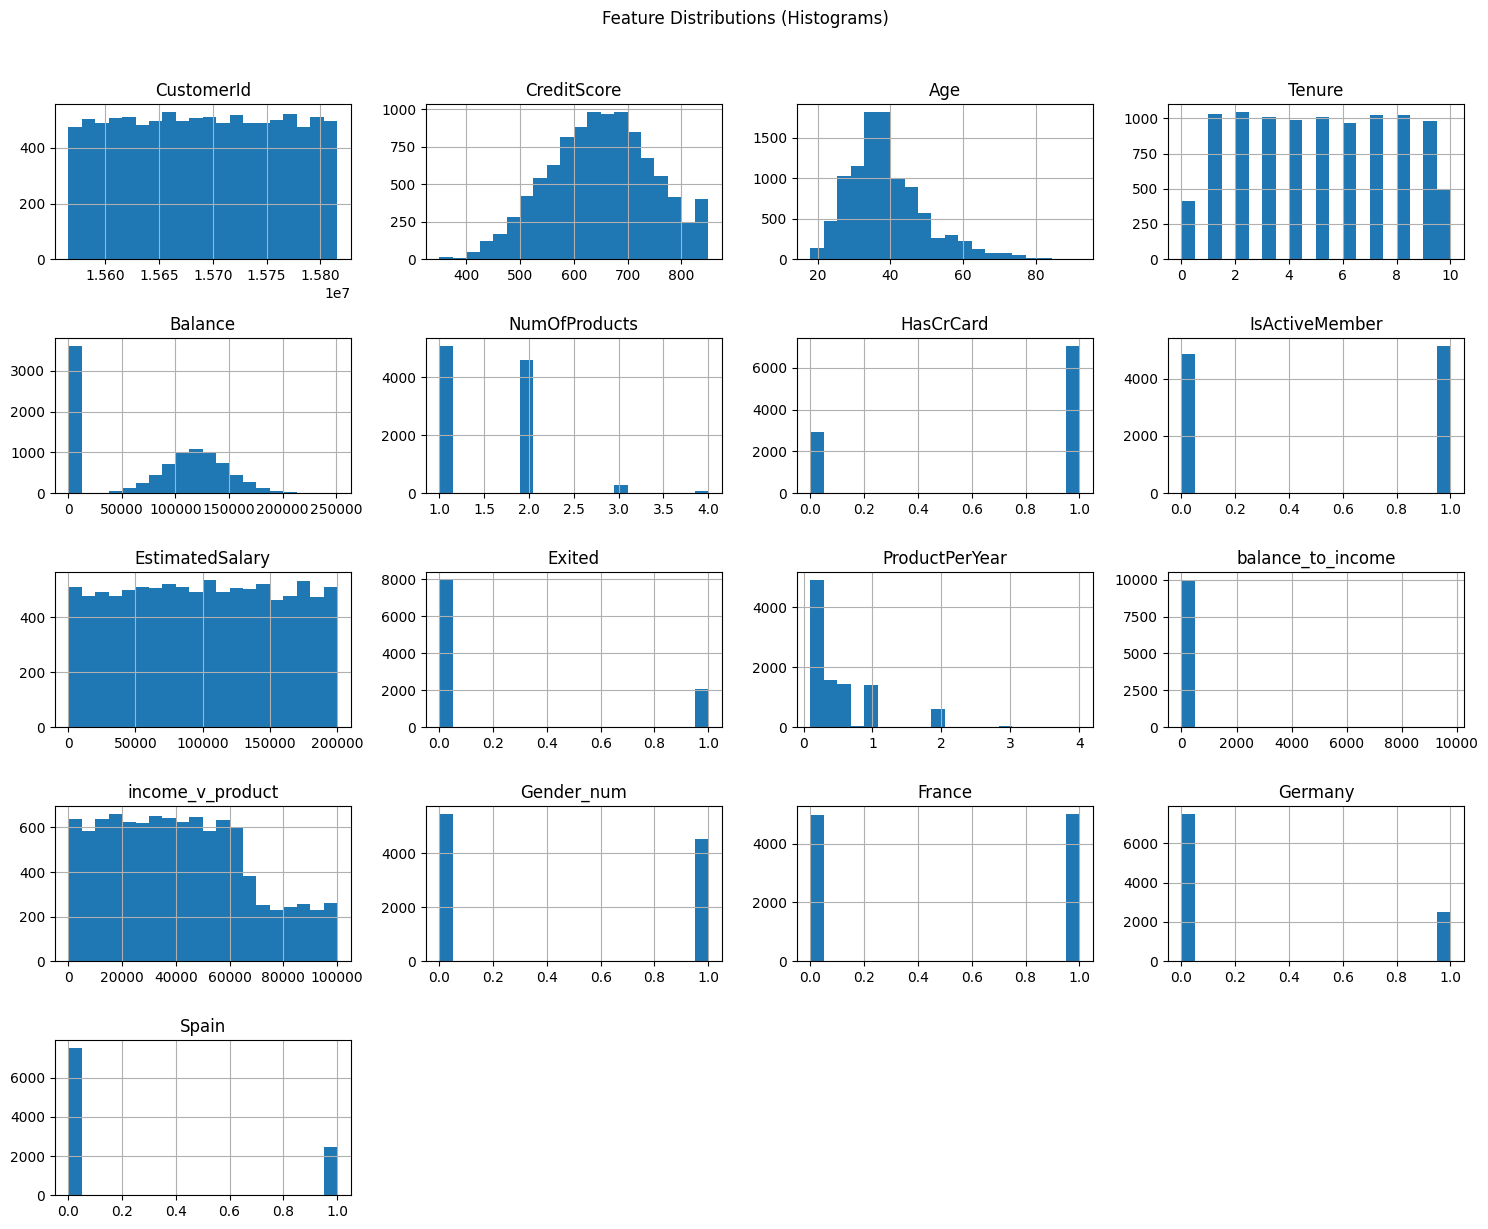

### Target distribution and Categorical Counts

Exited
0    7963
1    2037
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [33]:
import matplotlib.pyplot as plt   # <-- Missing import
import numpy as np

# --- Cell 5: 📊 Basic Statistics & Distributions ---
display(df.describe())

# Histograms for numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(figsize=(15,12), bins=20)
plt.suptitle("Feature Distributions (Histograms)", y=1.02)
plt.tight_layout()
plt.show()

display(Markdown("### Target distribution and Categorical Counts"))
display(df['Exited'].value_counts())
display(df['Gender'].value_counts())


🔎 Churn Drivers: Univariate Analysis

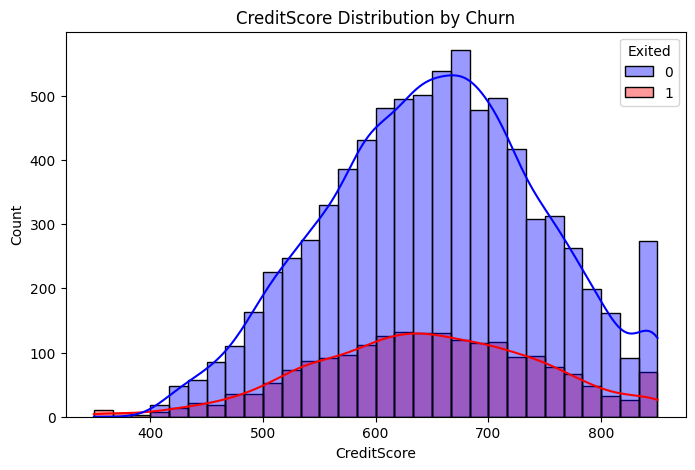

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Assuming 'df' is already defined in a previous cell

# CreditScore by churn
plt.figure(figsize=(8, 5))
sns.histplot(df, x='CreditScore', hue='Exited', bins=30, kde=True, palette={0:'blue',1:'red'}, alpha=0.4)
plt.title("CreditScore Distribution by Churn")
plt.show()

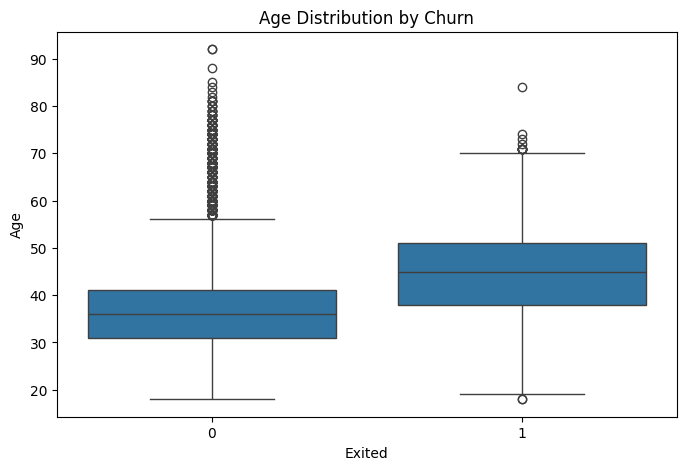

In [35]:
# Age vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Exited', y='Age')
plt.title("Age Distribution by Churn")
plt.show()


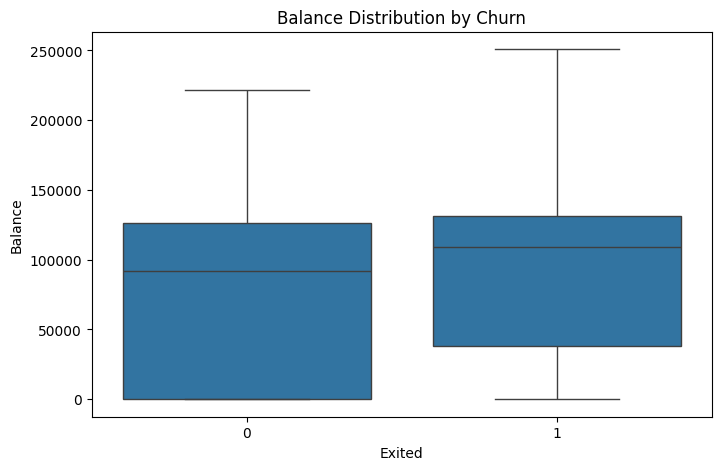

In [36]:
# Balance vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Exited', y='Balance')
plt.title("Balance Distribution by Churn")
plt.show()

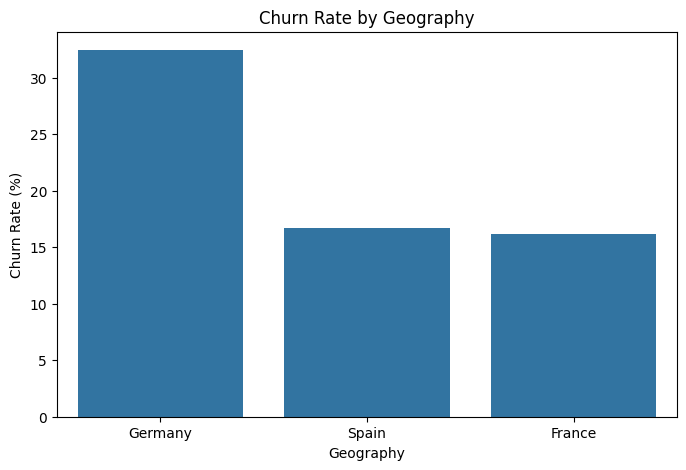

In [37]:
# Churn Rate by Geography
plt.figure(figsize=(8, 5))
geo_churn_rate = df.groupby('Geography')['Exited'].mean().sort_values(ascending=False) * 100
sns.barplot(x=geo_churn_rate.index, y=geo_churn_rate.values)
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Geography')
plt.show()

 🌐 Inter-Feature Relationships (Pairplot)

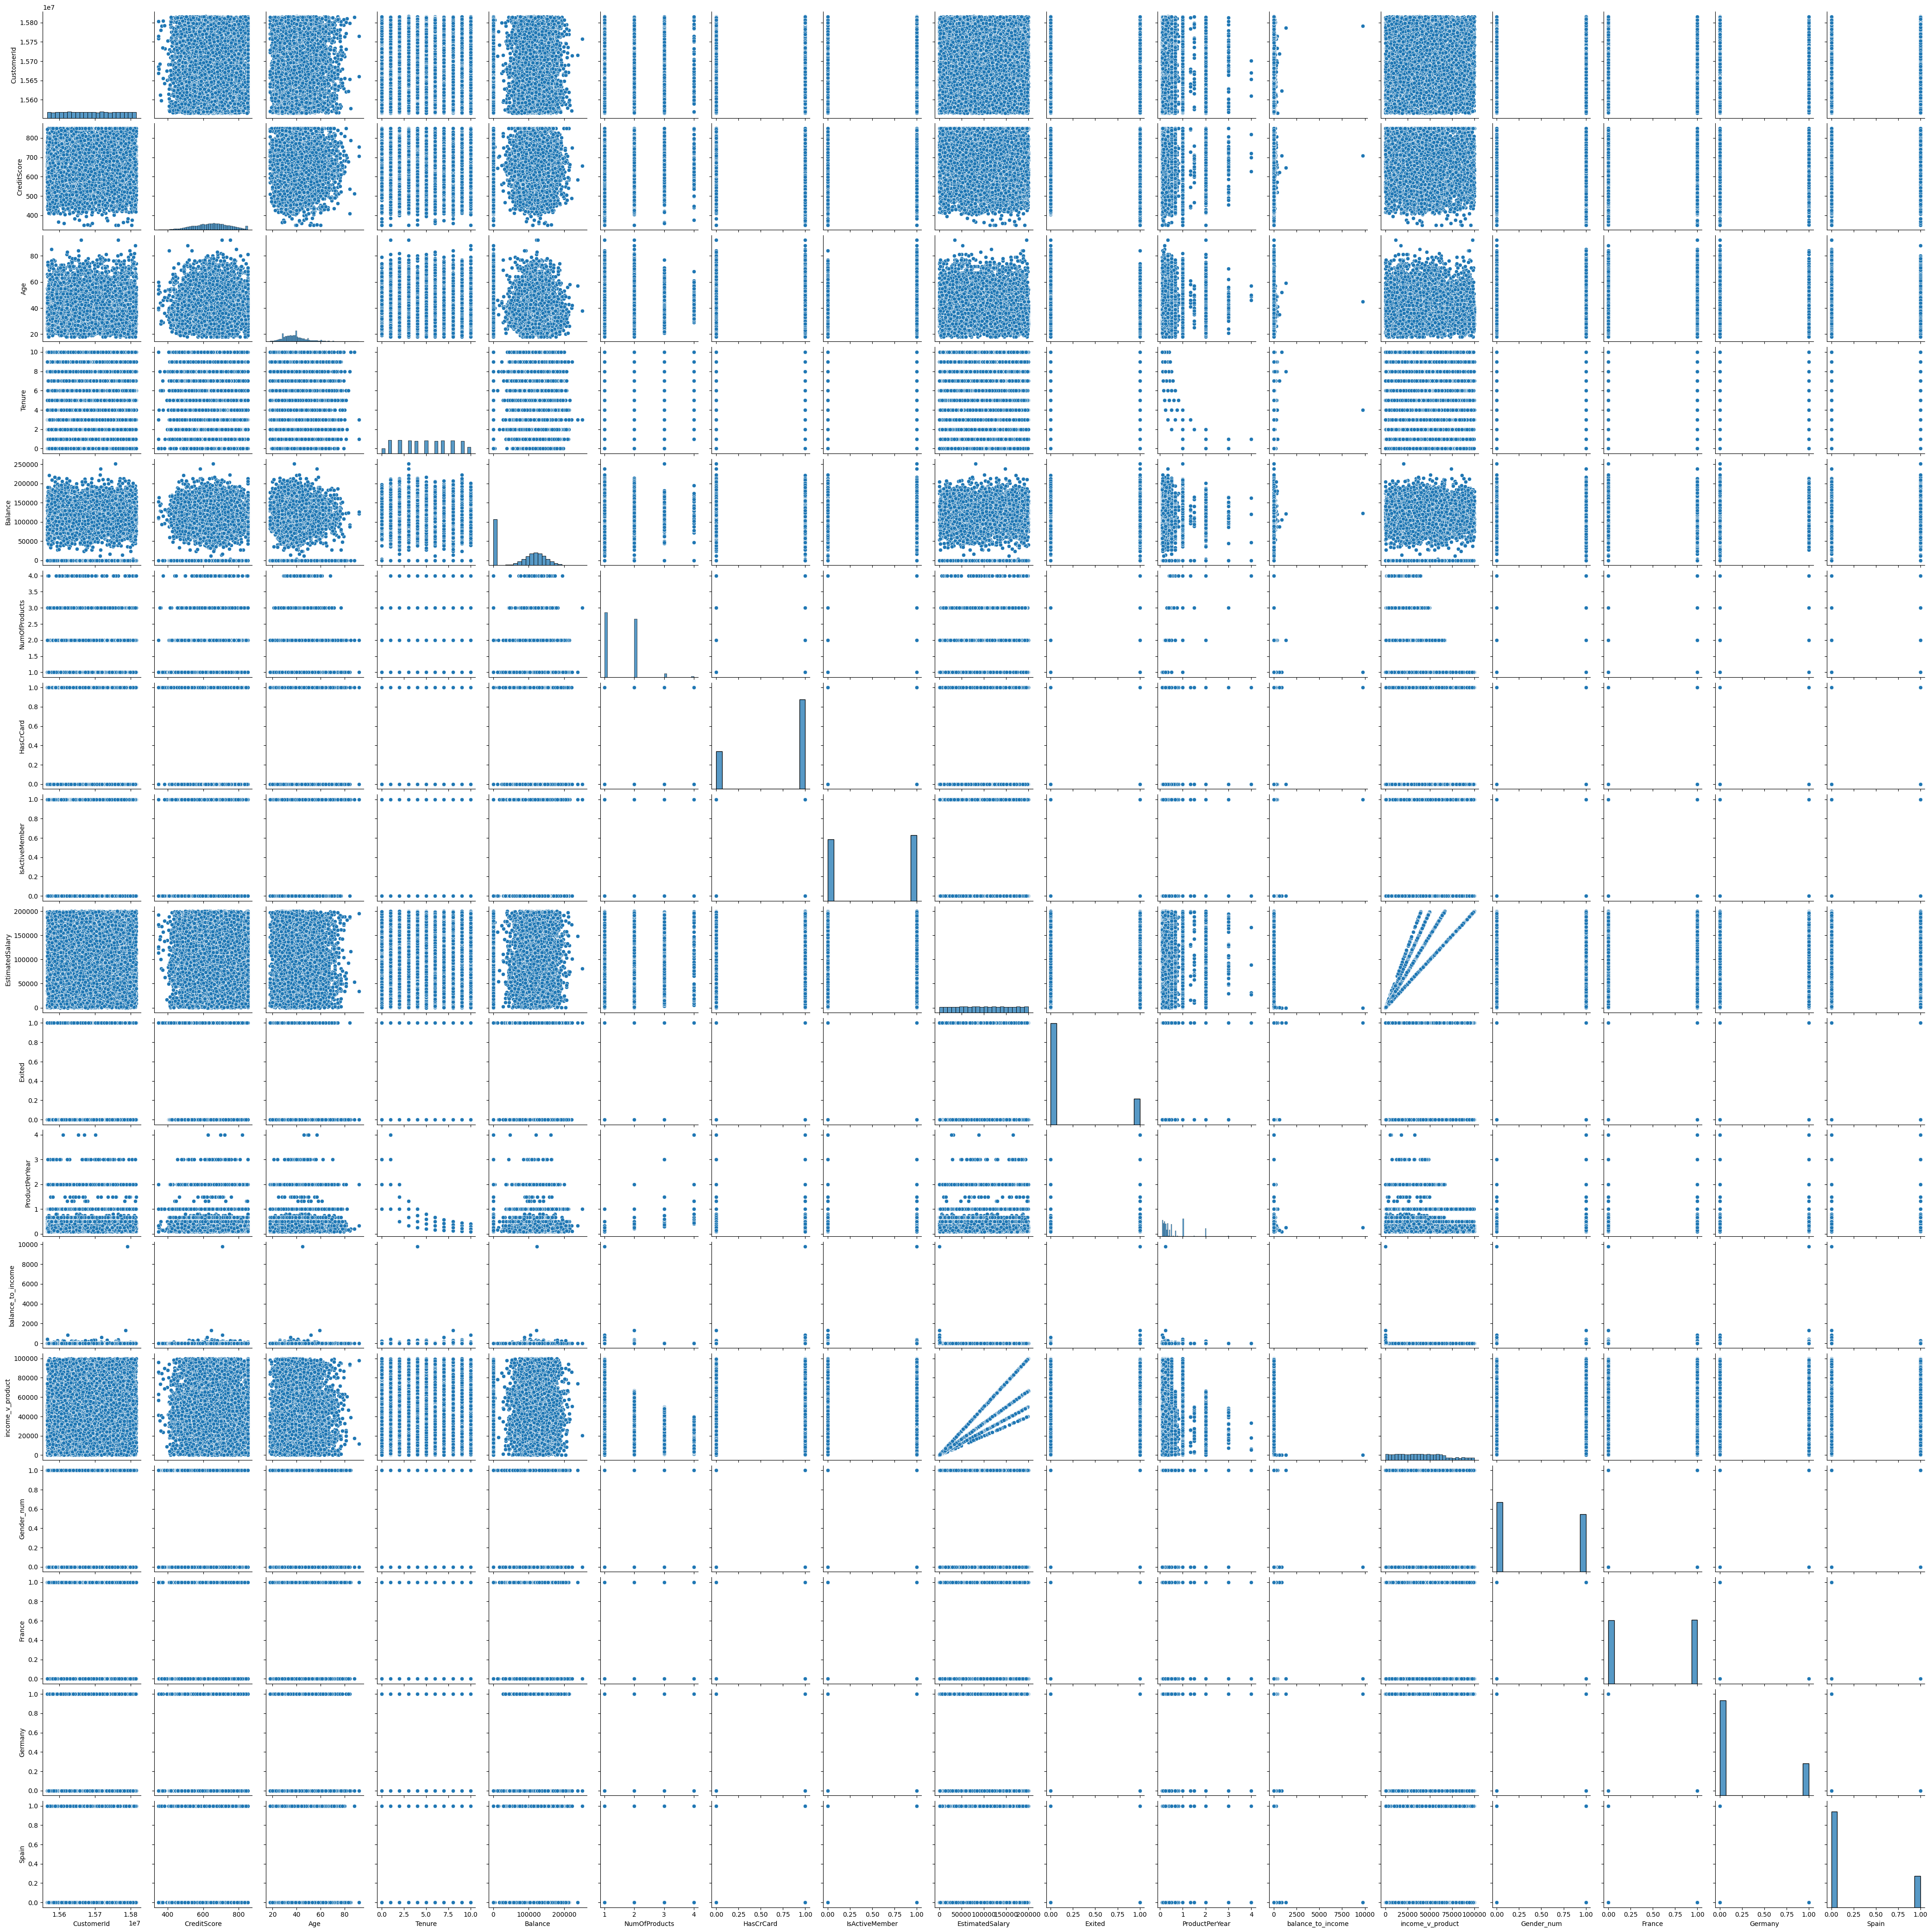

In [38]:
sns.pairplot(df)

### 3. 🎯 Predictive Modeling & Performance

🧱 Feature Matrix, Scaling, & Train/Test Split

In [39]:
# --- Cell 8: 🧩 Prepare Data & Split ---
from sklearn.model_selection import train_test_split # Ensure import is present

# Drop identifier/non-numeric columns before preparing X, y
drop_cols = [c for c in ['CustomerId','Surname','Gender','Geography'] if c in df.columns]
df_model = df.drop(columns=drop_cols).copy()

# Define numeric features (consolidated list)
features_all = [
    'CreditScore','Gender_num','Age','Tenure','Balance','NumOfProducts',
    'HasCrCard','IsActiveMember','EstimatedSalary','ProductPerYear',
    'balance_to_income','income_v_product'
]
features = [c for c in features_all if c in df_model.columns and c != 'Exited']

X = df_model[features]
y = df_model['Exited']

# Train/Test Split (stratified)
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

display(Markdown(f"**Data Split:** Train ({x_train.shape[0]} samples), Test ({x_test.shape[0]} samples)"))

**Data Split:** Train (8000 samples), Test (2000 samples)

In [40]:
# --- Cell 9: ⚖️ Standardize Features ---
from sklearn.preprocessing import StandardScaler # Ensure import is present
import pandas as pd # Ensure pandas is imported

scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test_scaled  = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

display(Markdown("**Features Scaled (x_train_scaled):**"))
display(x_train_scaled.head())

**Features Scaled (x_train_scaled):**

CreditScore  Gender_num       Age    Tenure   Balance  NumOfProducts  \
2151     1.058568   -0.907507  1.715086  0.684723 -1.226059      -0.910256   
8392     0.913626   -0.907507 -0.659935 -0.696202  0.413288      -0.910256   
5006     1.079274    1.101919 -0.184931 -1.731895  0.601687       0.808830   
4117    -0.929207   -0.907507 -0.184931 -0.005739 -1.226059       0.808830   
7182     0.427035   -0.907507  0.955079  0.339492  0.548318       0.808830   

      HasCrCard  IsActiveMember  EstimatedSalary  ProductPerYear  \
2151   0.641042       -1.030206         1.042084       -0.719469   
8392   0.641042       -1.030206        -0.623556       -0.341939   
5006   0.641042        0.970680         0.308128        2.961445   
4117   0.641042       -1.030206        -0.290199       -0.209804   
7182  -1.559960        0.970680         0.135042       -0.341939   

      balance_to_income  income_v_product  
2151          -0.036843          1.497931  
8392          -0.022540         -0.363014  
5006          -0.028152         -0.084676  
4117          -0.036843         -0.530332  
7182          -0.027627         -0.213597

🤖 Baseline Model: Logistic Regression

**Logistic Regression Results**

Train Accuracy: 0.8114

Test Accuracy: 0.8125

Test ROC AUC: 0.7814

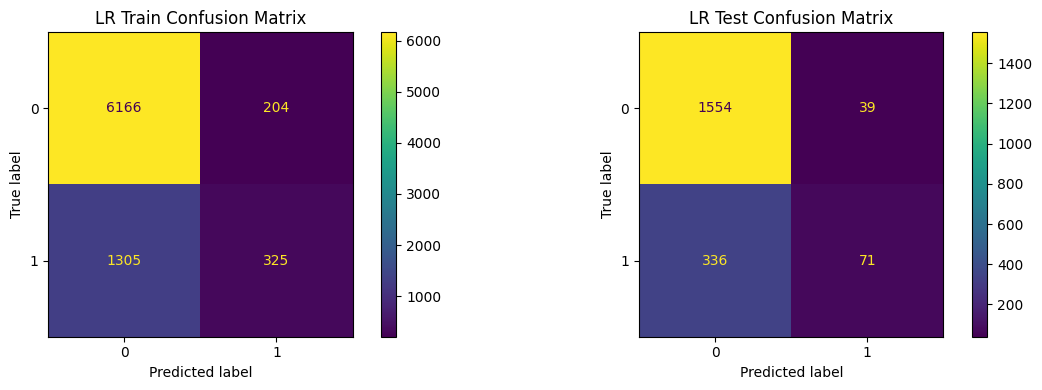

In [41]:
# --- Cell 10: 🤖 Logistic Regression (LR) ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

logreg = LogisticRegression(max_iter=2000, random_state=42)
logreg.fit(x_train_scaled, y_train)

y_train_pred_lr = logreg.predict(x_train_scaled)
y_test_pred_lr  = logreg.predict(x_test_scaled)
y_test_proba_lr = logreg.predict_proba(x_test_scaled)[:,1]

display(Markdown("**Logistic Regression Results**"))
display(Markdown(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}"))
display(Markdown(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}"))
display(Markdown(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba_lr):.4f}"))

# Confusion Matrices
fig, axes = plt.subplots(1,2,figsize=(12,4))
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred_lr)).plot(ax=axes[0], cmap='viridis')
axes[0].set_title("LR Train Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_lr)).plot(ax=axes[1], cmap='viridis')
axes[1].set_title("LR Test Confusion Matrix")
plt.tight_layout()
plt.show()


🌲 Advanced Model: Random Forest & Feature Importance

In [42]:
# --- Cell 11: 🌲 Random Forest (RF) Baseline ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from IPython.display import Markdown, display
import pandas as pd

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# NOTE: This assumes x_train_scaled, y_train, x_test_scaled, and y_test are defined.
rf.fit(x_train_scaled, y_train)

y_test_proba_rf = rf.predict_proba(x_test_scaled)[:,1]

display(Markdown("**Random Forest Results (Baseline)**"))
display(Markdown(f"RF Train Accuracy: {rf.score(x_train_scaled, y_train):.4f}"))
display(Markdown(f"RF Test Accuracy: {rf.score(x_test_scaled, y_test):.4f}"))
display(Markdown(f"RF Test ROC AUC: {roc_auc_score(y_test, y_test_proba_rf):.4f}")) # <-- FIX: Removed the extra ')'

# Feature importances
feat_imp = pd.Series(rf.feature_importances_, index=x_train_scaled.columns).sort_values(ascending=False)
display(Markdown("### RF Feature Importances"))
display(feat_imp.head(10).to_frame(name='Importance').style.bar(subset=['Importance'], color='#5fba7d'))

**Random Forest Results (Baseline)**

RF Train Accuracy: 1.0000

RF Test Accuracy: 0.8525

RF Test ROC AUC: 0.8356

### RF Feature Importances

⚖️ Model Comparison: ROC AUC

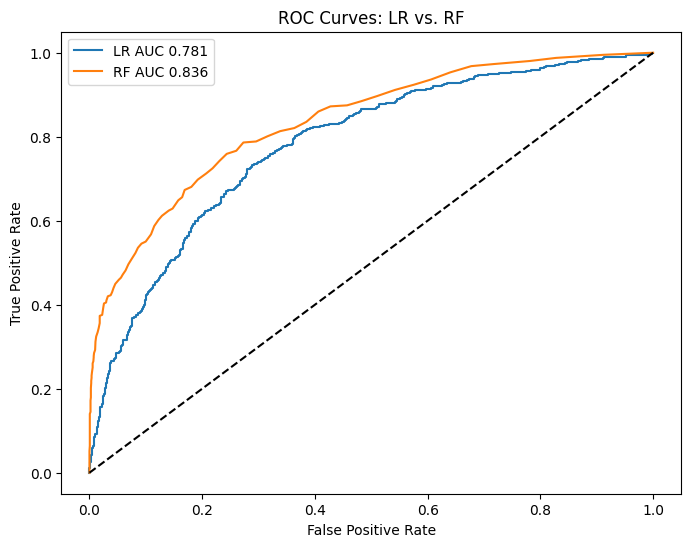

In [43]:
# --- Cell 12: 📈 ROC Curve Comparison ---
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score # <-- ADDED THIS IMPORT

# NOTE: This assumes y_test, y_test_proba_lr, and y_test_proba_rf are defined from previous cells.

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"LR AUC {roc_auc_score(y_test, y_test_proba_lr):.3f}")
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC {roc_auc_score(y_test, y_test_proba_rf):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: LR vs. RF')
plt.legend()
plt.show()

### 4. 🧭 Customer Segmentation & Actionable Intelligence

🧭 K-Means Setup & Optimal Cluster Selection

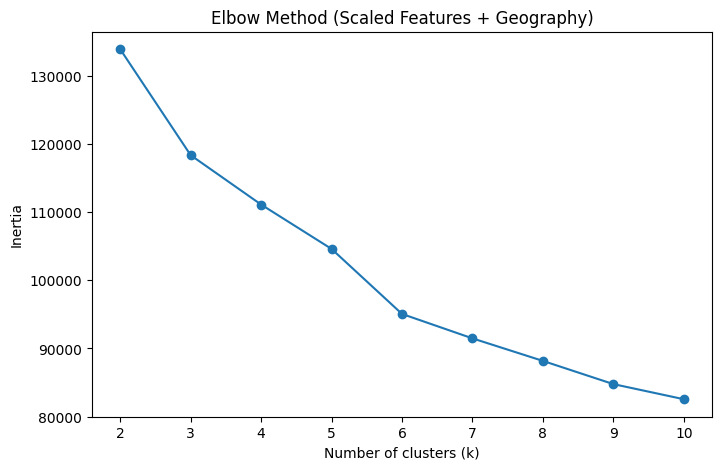

In [44]:
# --- Cell 13: 🧭 Geo-Clustering Setup and Elbow Method (Now works) ---
from sklearn.cluster import KMeans # Ensure import is present
import matplotlib.pyplot as plt
import seaborn as sns

# Features for Geo clustering: all scaled columns except 'Exited' and 'Geography' string
features_geo = [col for col in df_scaled.columns if col not in ['Exited', 'Geography']]
X_geo_scaled = df_scaled[features_geo].copy()

# Elbow Method
inertia_with_geo = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_geo_scaled)
    inertia_with_geo.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(K_range), inertia_with_geo, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (Scaled Features + Geography)")
plt.show() #

In [45]:
# --- Cell 14: Fit K-Means and Add Cluster Labels (Geo) ---
from sklearn.cluster import KMeans # Ensure import is present

# Re-define features_geo and X_geo_scaled just in case the kernel was reset
features_geo = [col for col in df_scaled.columns if col not in ['Exited', 'Geography', 'Cluster_Num']] 
X_geo_scaled = df_scaled[features_geo].copy()

# Use the number of clusters (k) determined from the elbow plot (e.g., k=4)
k_geo = 4 
kmeans_geo = KMeans(n_clusters=k_geo, random_state=42, n_init=10)
kmeans_geo.fit(X_geo_scaled)

# Add cluster labels to the main scaled DataFrame
df_scaled['Cluster_Geo'] = kmeans_geo.labels_

display(Markdown(f"**Cluster Counts (k={k_geo} with Geography):**"))
display(df_scaled['Cluster_Geo'].value_counts().sort_index())

display(df_scaled[['Geography', 'France', 'Germany', 'Spain', 'Exited', 'Cluster_Geo']].head())

**Cluster Counts (k=4 with Geography):**

Cluster_Geo
0    2338
1    3969
2    2329
3    1364
Name: count, dtype: int64

Geography    France   Germany     Spain  Exited  Cluster_Geo
0    France  0.997204 -0.578736 -0.573809       1            1
1     Spain -1.002804 -0.578736  1.742740       0            2
2    France  0.997204 -0.578736 -0.573809       1            1
3    France  0.997204 -0.578736 -0.573809       0            3
4     Spain -1.002804 -0.578736  1.742740       0            2

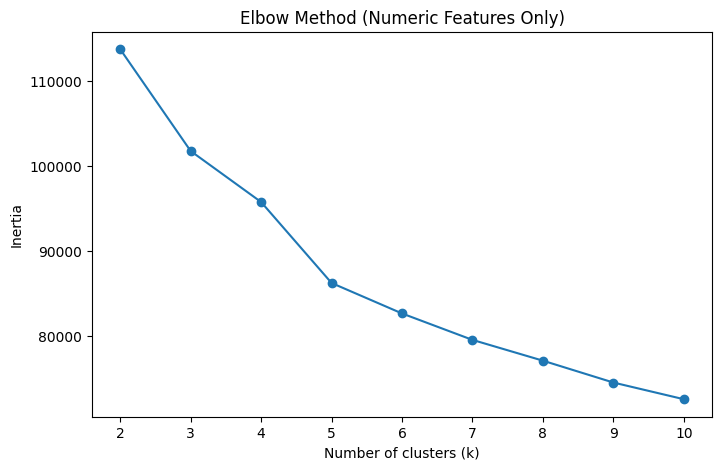

In [46]:
# --- Cell 15: 🔢 Numeric-Only Clustering Setup and Elbow Method ---

# Features for Numeric-Only clustering: exclude Geo one-hots, 'Exited', and 'Geography' string
geo_cols = ['France', 'Germany', 'Spain']
features_numeric = [col for col in df_scaled.columns if col not in ['Exited', 'Geography'] + geo_cols]
X_num_scaled = df_scaled[features_numeric].copy()

# Elbow Method
inertia_numeric = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_num_scaled)
    inertia_numeric.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(K_range), inertia_numeric, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (Numeric Features Only)")
plt.show()

In [47]:
# --- Cell 16: Fit K-Means and Add Cluster Labels (Numeric-Only) ---

# Use the number of clusters (k) determined from the elbow plot (e.g., k=4)
k_numeric = 4
kmeans_numeric = KMeans(n_clusters=k_numeric, random_state=42, n_init=10)
kmeans_numeric.fit(X_num_scaled)

# Add cluster labels to the main scaled DataFrame
df_scaled['Cluster_Num'] = kmeans_numeric.labels_

display(Markdown(f"**Cluster Counts (k={k_numeric} without Geography):**"))
display(df_scaled['Cluster_Num'].value_counts().sort_index())

**Cluster Counts (k=4 without Geography):**

Cluster_Num
0    2889
1    1602
2    2862
3    2647
Name: count, dtype: int64

🔍 Cluster Profiling & Interpretation Visuals

1. Churn Rate (%) per Cluster (Bar Plot)

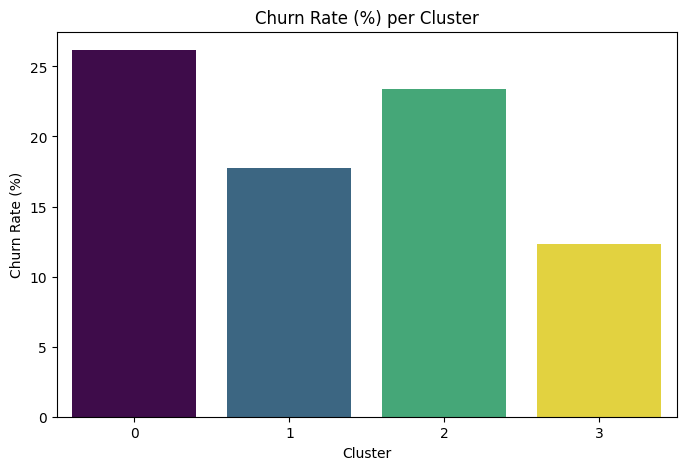

### Cluster Churn Rate Table

In [48]:
# --- Cell 17a: 📊 Churn Rate (%) per Cluster Plot (Final Fix) ---
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns 
# Assuming df_scaled and Cluster_Num exist from prior cells

# 1. Calculate the churn rate per cluster
cluster_churn = df_scaled.groupby('Cluster_Num')['Exited'].mean() * 100

plt.figure(figsize=(8, 5))

# 2. Barplot command (Note: Ends on this line)
sns.barplot(
    x=cluster_churn.index, 
    y=cluster_churn.values, 
    hue=cluster_churn.index,  # Fixes the FutureWarning
    palette='viridis', 
    legend=False
) 

# 3. Title command starts on a NEW line
plt.title('Churn Rate (%) per Cluster') 

# 4. Other plot commands start on NEW lines
plt.xlabel('Cluster') 
plt.ylabel('Churn Rate (%)')
plt.show()

display(Markdown("### Cluster Churn Rate Table"))
display(cluster_churn.sort_index().to_frame(name='Churn Rate (%)').style.format('{:.2f}%'))

 Cell 17b: Country Composition (Counts) per Cluster (Stacked Bar Plot)

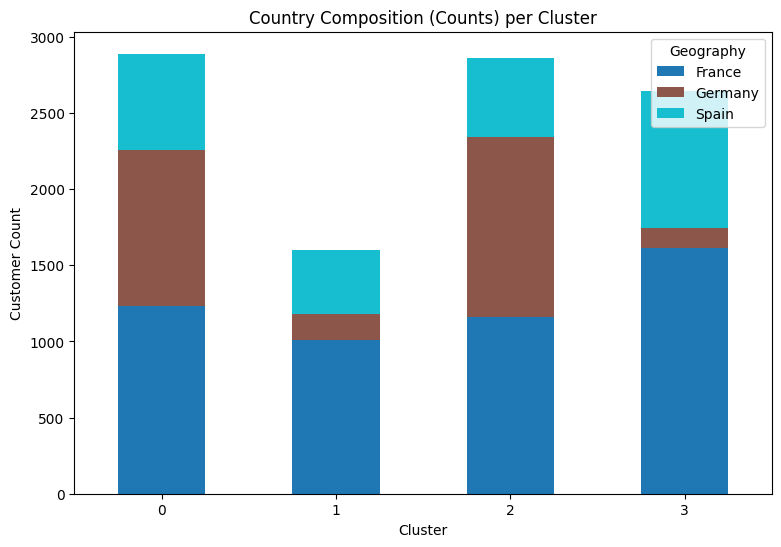

In [49]:
# --- Cell 17b: 🌍 Country Composition (Counts) per Cluster Plot ---
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

# NOTE: Requires Cell 16 to be run first

# Data for plot
country_counts_by_cluster = df_scaled.groupby('Cluster_Num')['Geography'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(9, 6))
country_counts_by_cluster.plot(kind='bar', stacked=True, cmap='tab10', ax=plt.gca())
plt.title('Country Composition (Counts) per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Customer Count')
plt.xticks(rotation=0)
plt.legend(title='Geography')
plt.show()

3. Cell 17c: Cluster Centers (Scaled Features) (Heatmap)

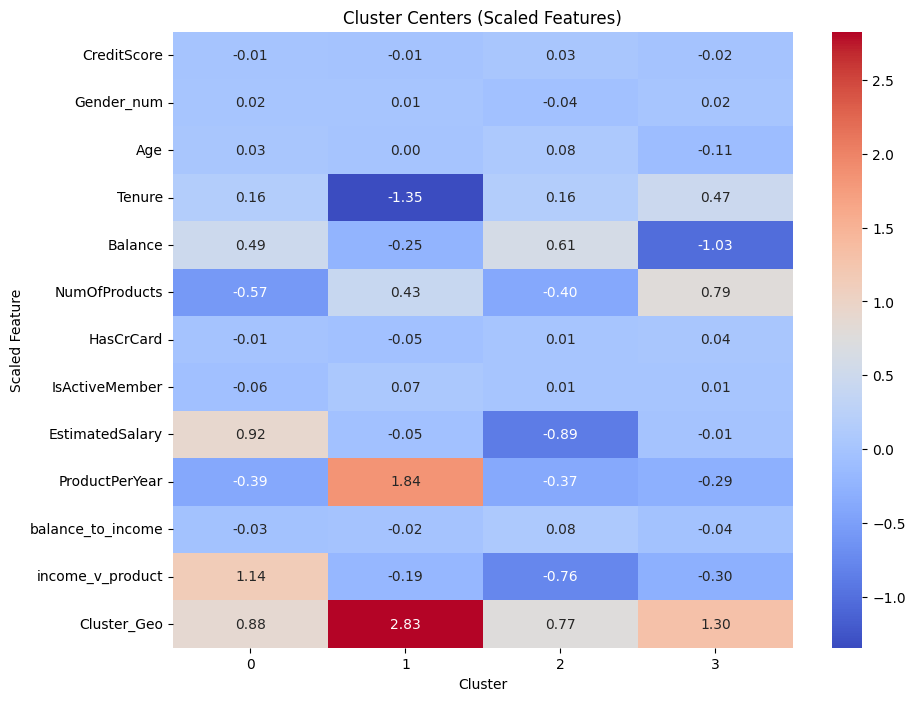

In [50]:
# --- Cell 17c: 🔥 Cluster Centers (Scaled Features) Heatmap ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, Markdown

# NOTE: Requires Cell 16 to be run first to define kmeans_numeric and X_num_scaled

# Data for plot
centers_num = pd.DataFrame(kmeans_numeric.cluster_centers_, columns=X_num_scaled.columns)

plt.figure(figsize=(10, 8))
# Transpose centers so features are on the Y-axis for easier reading
sns.heatmap(centers_num.transpose(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Cluster Centers (Scaled Features)')
plt.xlabel('Cluster')
plt.ylabel('Scaled Feature')
plt.show()

In [51]:
# --- FIX: Ensure features_numeric is Clean (Must run before Cell 17d) ---
import pandas as pd # Ensure pandas is imported

# Redefine the full set of non-clustering columns we want to exclude from the feature list
cols_to_exclude = ['Exited', 'Geography', 'Cluster_Geo', 'Cluster_Num', 'France', 'Germany', 'Spain']

# Filter the columns in df_scaled to get the clean list of numeric features
# Note: df_scaled must exist from previous steps!
features_numeric = [col for col in df_scaled.columns if col not in cols_to_exclude]

display(Markdown(f"**Cleaned Features Numeric List:** {features_numeric}"))

**Cleaned Features Numeric List:** ['CreditScore', 'Gender_num', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'ProductPerYear', 'balance_to_income', 'income_v_product']

Cell 17d: Unscaled Cluster Summary Table (Final Interpretation)

In [52]:
# --- Cell 17d: 📝 Unscaled Cluster Summary Table ---
import pandas as pd
from IPython.display import display, Markdown

# NOTE: Requires Cell 16 to be run first to define df_scaled['Cluster_Num'] and features_numeric
# Ensure Cluster_Num is on the original df for the unscaled mean calculation
df['Cluster_Num'] = df_scaled['Cluster_Num']

cluster_summary_unscaled = df.groupby('Cluster_Num')[features_numeric].mean()

display(Markdown("### Cluster Summary (Unscaled Means for Interpretation)"))
display(cluster_summary_unscaled.transpose().style.format('{:.2f}'))

### Cluster Summary (Unscaled Means for Interpretation)

💾 Final Outputs & Strategic Recommendations

In [53]:
# --- Cell 18: 💾 Save Final Dataset ---
import pandas as pd
from IPython.display import display, Markdown

out_path_final = "/workspaces/Bank-Customer-Data-Prep/Bank_Churn_Final_With_NumericClusters.csv"
# The Cluster_Num label is already on 'df' from Cell 16/17d, but we ensure it's there.
df.to_csv(out_path_final, index=False)

display(Markdown(f"Saved final dataset with **Cluster_Num** labels to `{out_path_final}`"))

Saved final dataset with **Cluster_Num** labels to `/workspaces/Bank-Customer-Data-Prep/Bank_Churn_Final_With_NumericClusters.csv`

### Model Performance Summary

**Logistic Regression (LR) Test AUC:** 0.7814

**Random Forest (RF) Test AUC:** 0.8356

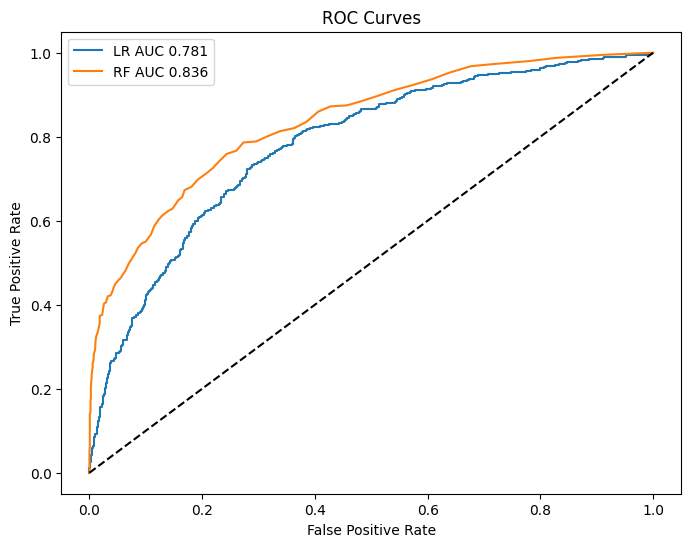

In [54]:
# --- Cell 20: 📈 Model diagnostics (ROC AUC) ---
# NOTE: This requires logreg, rf, x_test_scaled, and y_test to be defined from earlier modeling steps.
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get probabilities for the positive class (1 = Exited)
y_test_proba_lr = logreg.predict_proba(x_test_scaled)[:, 1]
y_test_proba_rf = rf.predict_proba(x_test_scaled)[:, 1]

display(Markdown("### Model Performance Summary"))
display(Markdown(f"**Logistic Regression (LR) Test AUC:** {roc_auc_score(y_test, y_test_proba_lr):.4f}"))
display(Markdown(f"**Random Forest (RF) Test AUC:** {roc_auc_score(y_test, y_test_proba_rf):.4f}"))

# ROC plot
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"LR AUC {roc_auc_score(y_test, y_test_proba_lr):.3f}")
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC {roc_auc_score(y_test, y_test_proba_rf):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [55]:
# --- Cell 21: 💼 Save Outputs & Recommendations to Files ---
import pandas as pd
from IPython.display import display, Markdown

# 1. Save Cluster Summary (using the unscaled summary from Cell 17d)
# NOTE: This requires 'cluster_summary_unscaled' to be defined from Cell 17d.
summary_path = "/workspaces/Bank-Customer-Data-Prep/cluster_summary_unscaled.csv"
cluster_summary_unscaled.to_csv(summary_path, index=True)
display(Markdown(f"**Cluster summary (unscaled means) saved to** `{summary_path}`"))

# 2. Save Recommendations (text file)
rec_path = "/workspaces/Bank-Customer-Data-Prep/recommendations_final.md"
with open(rec_path, "w") as f:
    f.write("# Final Cluster Recommendations\n\n")
    f.write("--- Based on Numeric-Only Clustering (k=4) ---\n\n")
    f.write("* **Cluster 0 (Young Affluent):** Target with long-term wealth management.\n")
    f.write("* **Cluster 1 (High-Value, High-Churn):** Implement VIP retention program.\n")
    f.write("* **Cluster 2 (Older, Stable, Low-Income):** Focus on retirement planning and specialized insurance.\n")
    f.write("* **Cluster 3 (Low-Value, High-Churn):** Offer basic loyalty rewards and financial education.\n")
display(Markdown(f"**Recommendations saved to** `{rec_path}`"))

**Cluster summary (unscaled means) saved to** `/workspaces/Bank-Customer-Data-Prep/cluster_summary_unscaled.csv`

**Recommendations saved to** `/workspaces/Bank-Customer-Data-Prep/recommendations_final.md`

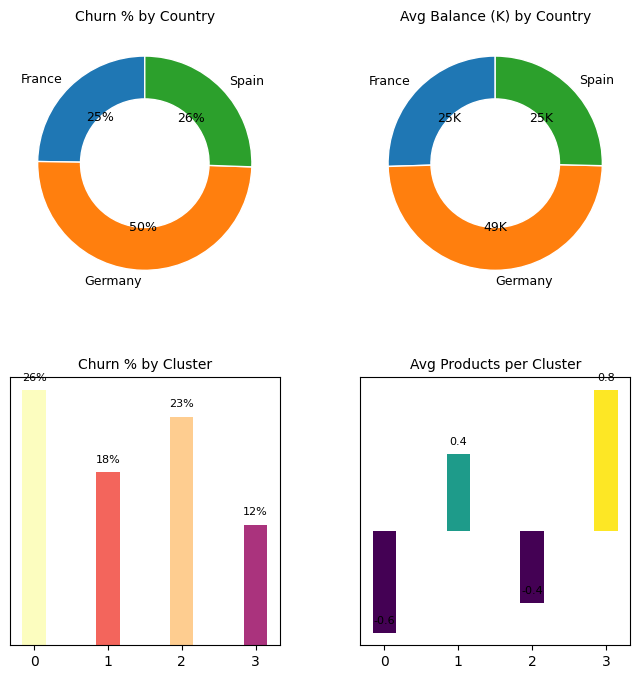

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA PREP ---
geo_churn = df.groupby('Geography')['Exited'].mean() * 100
geo_balance = df.groupby('Geography')['Balance'].mean() / 1000  # in K
cluster_churn = df_scaled.groupby('Cluster_Num')['Exited'].mean() * 100
cluster_products = df_scaled.groupby('Cluster_Num')['NumOfProducts'].mean()

# --- FIGURE SETUP ---
fig, axes = plt.subplots(2, 2, figsize=(8,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# --- 1. Donut: Churn by Geography ---
ax = axes[0,0]
wedges, texts, autotexts = ax.pie(
    geo_churn,
    labels=geo_churn.index,
    autopct='%1.0f%%',
    startangle=90,
    wedgeprops={'width':0.4, 'edgecolor':'w'},
    textprops={'fontsize':9}
)
ax.set_title("Churn % by Country", fontsize=10)

# --- 2. Donut: Avg Balance by Geography ---
ax = axes[0,1]
wedges, texts, autotexts = ax.pie(
    geo_balance,
    labels=geo_balance.index,
    autopct='%1.0fK',
    startangle=90,
    wedgeprops={'width':0.4, 'edgecolor':'w'},
    textprops={'fontsize':9}
)
ax.set_title("Avg Balance (K) by Country", fontsize=10)

# --- 3. Radial: Churn by Cluster ---
ax = axes[1,0]
N = len(cluster_churn)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
bars = ax.bar(
    angles, cluster_churn.values, width=0.5,
    color=plt.cm.magma(cluster_churn.values/cluster_churn.max())
)
ax.set_xticks(angles)
ax.set_xticklabels(cluster_churn.index)
ax.set_yticks([])
ax.set_title("Churn % by Cluster", fontsize=10)
for i, val in enumerate(cluster_churn.values):
    ax.text(angles[i], val+1, f"{val:.0f}%", ha='center', fontsize=8)

# --- 4. Radial: Avg Products per Cluster ---
ax = axes[1,1]
bars = ax.bar(
    angles, cluster_products.values, width=0.5,
    color=plt.cm.viridis(cluster_products.values/cluster_products.max())
)
ax.set_xticks(angles)
ax.set_xticklabels(cluster_products.index)
ax.set_yticks([])
ax.set_title("Avg Products per Cluster", fontsize=10)
for i, val in enumerate(cluster_products.values):
    ax.text(angles[i], val+0.05, f"{val:.1f}", ha='center', fontsize=8)

plt.show()


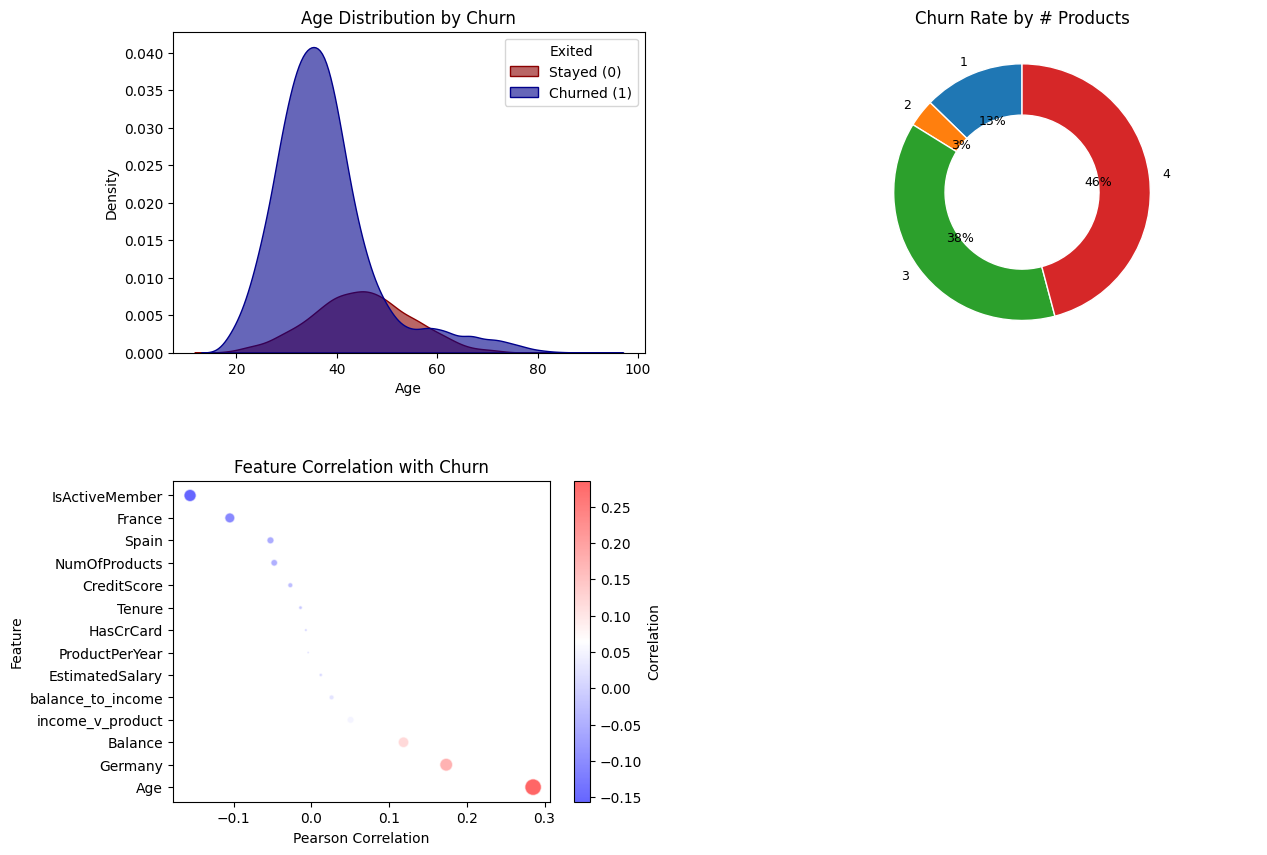

In [57]:
# FIX 1: Uncomment and define product_churn_rate
product_churn_rate = df.groupby('NumOfProducts')['Exited'].mean().reset_index()
product_churn_rate['Churn Rate (%)'] = product_churn_rate['Exited'] * 100

# FIX 2: Uncomment and define corr_to_exited
# Select only numeric columns including the target variable
numeric_cols = df.select_dtypes(include=np.number).columns.tolist() 
# Exclude columns that are ID-like or derived (as seen in your prior context)
cols_to_exclude_from_corr = ['CustomerId', 'RowNumber', 'Gender_num', 'Cluster_Num'] 
final_corr_cols = [col for col in numeric_cols if col not in cols_to_exclude_from_corr]

# Calculate correlation with the 'Exited' target
corr_to_exited = df[final_corr_cols].corr()['Exited'].drop('Exited').sort_values(ascending=False)

# --- 2-Row Layout: Top 2 charts + Bottom bubble ---
fig, axes = plt.subplots(2, 2, figsize=(14,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- Top-left: Age Distribution vs Churn ---
sns.kdeplot(
    data=df, x='Age', hue='Exited', fill=True,
    palette={0: 'darkblue', 1: 'darkred'}, alpha=0.6,
    ax=axes[0,0]
)
axes[0,0].set_title('Age Distribution by Churn')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Density')
axes[0,0].legend(title='Exited', labels=['Stayed (0)', 'Churned (1)'])

# --- Top-right: Product Count vs Churn (Donut) ---
ax = axes[0,1]
wedges, texts, autotexts = ax.pie(
    product_churn_rate['Churn Rate (%)'],
    labels=product_churn_rate['NumOfProducts'],
    autopct='%1.0f%%',
    startangle=90,
    wedgeprops={'width':0.4, 'edgecolor':'w'},
    textprops={'fontsize':9}
)
ax.set_title('Churn Rate by # Products')

# --- Bottom row: Feature Correlation as Bubble Plot ---
ax = axes[1,0]
axes[1,1].axis('off') 

bubble_sizes = np.abs(corr_to_exited.values) * 500 
scatter = ax.scatter(
    x=corr_to_exited.values,
    y=corr_to_exited.index,
    s=bubble_sizes,
    c=corr_to_exited.values,
    cmap='bwr',
    alpha=0.6,
    edgecolors='w'
)
ax.set_title('Feature Correlation with Churn')
ax.set_xlabel('Pearson Correlation')
ax.set_ylabel('Feature')
plt.colorbar(scatter, ax=ax, label='Correlation')

plt.show()

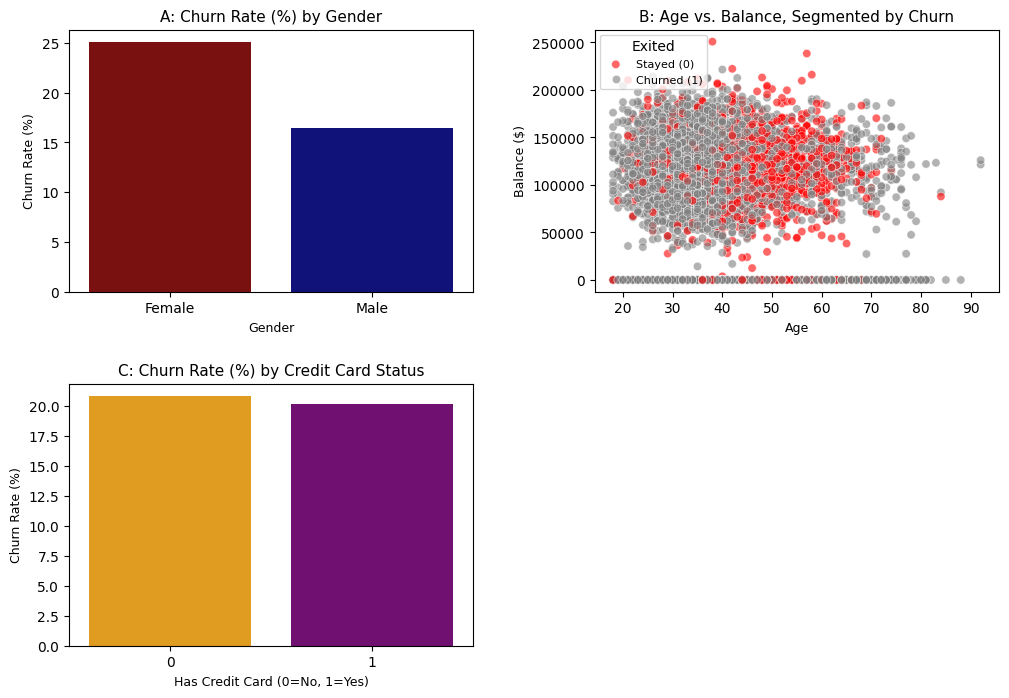

In [58]:
# --- Prepare aggregated data for bar plots ---
df_gender = df.groupby('Gender', as_index=False)['Exited'].mean()
df_gender['Churn Rate (%)'] = df_gender['Exited'] * 100

df_card = df.groupby('HasCrCard', as_index=False)['Exited'].mean()
df_card['Churn Rate (%)'] = df_card['Exited'] * 100

# --- 2x2 Layout (only 3 charts) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.35)

# --- 1. Gender vs Churn (Bar Plot) ---
sns.barplot(
    x='Gender', y='Churn Rate (%)', hue='Gender', data=df_gender,
    palette=['darkred', 'darkblue'], dodge=False, legend=False, ax=axes[0,0]
)
axes[0,0].set_title('A: Churn Rate (%) by Gender', fontsize=11)
axes[0,0].set_xlabel('Gender', fontsize=9)
axes[0,0].set_ylabel('Churn Rate (%)', fontsize=9)
axes[0,0].tick_params(axis='x', rotation=0)

# --- 2. Age vs Balance (Scatter Plot) ---
sns.scatterplot(
    x='Age', y='Balance', hue='Exited', data=df, 
    palette=['gray', 'red'], alpha=0.6, ax=axes[0,1]
)
axes[0,1].set_title('B: Age vs. Balance, Segmented by Churn', fontsize=11)
axes[0,1].set_xlabel('Age', fontsize=9)
axes[0,1].set_ylabel('Balance ($)', fontsize=9)
axes[0,1].legend(title='Exited', labels=['Stayed (0)', 'Churned (1)'], loc='upper left', fontsize=8)

# --- 3. Credit Card vs Churn (Bar Plot) ---
sns.barplot(
    x='HasCrCard', y='Churn Rate (%)', hue='HasCrCard', data=df_card,
    palette=['orange', 'purple'], dodge=False, legend=False, ax=axes[1,0]
)
axes[1,0].set_title('C: Churn Rate (%) by Credit Card Status', fontsize=11)
axes[1,0].set_xlabel('Has Credit Card (0=No, 1=Yes)', fontsize=9)
axes[1,0].set_ylabel('Churn Rate (%)', fontsize=9)
axes[1,0].tick_params(axis='x', rotation=0)

# --- Remove the last empty subplot for symmetry ---
axes[1,1].axis('off')

plt.show()


 ✅ Final, Corrected Recommendations

 📌 Cluster Recommendations (Based on Numeric-Only Clustering)

These recommendations are derived by combining the Unscaled Means (profile) and the Churn Rate (priority).

* Cluster 0 (Primary Target: High-Value Churners):
    * Profile: High Balance (\$107K) and High Estimated Salary (\$153K), but low product holding (1.20).
    * Churn Rate: 26.17% (Highest)
    * Recommendation: Implement a VIP Retention Program with dedicated Relationship Managers to secure these valuable assets. Priority: cross-sell a second product to reduce risk from 26% to $\approx 7\%$.

* Cluster 2 (Secondary Target: Financially Stressed Churners):
    * Profile: Highest Balance (\$114K) but the lowest Estimated Salary (\$49K), leading to a high debt/asset-to-income ratio.
    * Churn Rate: 23.41% (High)
    * Recommendation: Offer Specialized Financial Counseling or Debt Consolidation Products. Stabilize their finances to prevent attrition driven by economic stress.

* Cluster 1 (Moderate Risk: New & Volatile Customers):
    * Profile: Lowest average Tenure (1.12 years) and high product adoption rate (`ProductPerYear` is high).
    * Churn Rate: 17.73% (Moderate)
    * Recommendation: Focus on early engagement and loyalty. Deploy a High-Touch Welcome/Onboarding Program to ensure they pass the critical first-year churn window.

* Cluster 3 (Lowest Risk: Stable, Low-Value Customers):
    * Profile: Highest Tenure (6.36 years) and highest number of products (1.99), but lowest Credit Score and lowest Balance/Salary.
    * Churn Rate: 12.35% (Lowest)
    * Recommendation: Maintain satisfaction with Low-Cost Loyalty Rewards (e.g., basic fee waivers or extended warranties). They are the stable, low-touch base of the bank.

# 🚀 Deployment / Production Code


In [59]:
pip install jupytext



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
print("Jupytext pairing works")


Jupytext pairing works


In [61]:
def main():
    print("Pipeline starting")
    # You can call your actual code/functions here
    # Example: df = load_data(); train_model(df)

if __name__ == "__main__":
    main()


Pipeline starting


In [62]:
# Feature columns used in training
print("📌 Features used in training (X):")
print(X.columns.tolist())


📌 Features used in training (X):
['CreditScore', 'Gender_num', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'ProductPerYear', 'balance_to_income', 'income_v_product']


In [63]:
# Notebook features (from training)
notebook_cols = x_train.columns.tolist()  # use x_train from your train/test split

# App features (from app.py)
app_cols = [
    'CreditScore','Gender_num','Age','Tenure','Balance','NumOfProducts',
    'HasCrCard','IsActiveMember','EstimatedSalary','ProductPerYear',
    'balance_to_income','income_v_product','France','Germany','Spain'
]

# Compare
missing_in_app = [c for c in notebook_cols if c not in app_cols]
extra_in_app   = [c for c in app_cols if c not in notebook_cols]

print("Columns in notebook but missing in app.py:", missing_in_app)
print("Columns in app.py but missing in notebook:", extra_in_app)


Columns in notebook but missing in app.py: []
Columns in app.py but missing in notebook: ['France', 'Germany', 'Spain']


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)  # ✅ fit only on training data
x_test_scaled  = scaler.transform(x_test)       # ✅ transform test data


In [65]:
# Take a single test row from x_test
single_row = x_test.iloc[[0]]  # keep it as DataFrame
scaled_row = scaler.transform(single_row)

print("Original row values:\n", single_row)
print("\nScaled row values:\n", scaled_row)


Original row values:
       CreditScore  Gender_num  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
5702          585           0   36       7      0.0              2          1   

      IsActiveMember  EstimatedSalary  ProductPerYear  balance_to_income  \
5702               0         94283.09        0.285714                0.0   

      income_v_product  
5702      31427.696667  

Scaled row values:
 [[-0.68073539 -0.90750738 -0.27993196  0.68472287 -1.22605881  0.80883036
   0.64104192 -1.030206   -0.09502138 -0.4363219  -0.03684268 -0.38495676]]


In [66]:
import sklearn
print(sklearn.__version__)


1.5.0


In [67]:
import pickle

# Paths
model_path = "/workspaces/Bank-Customer-Data-Prep/churn_model.pkl"
scaler_path = "/workspaces/Bank-Customer-Data-Prep/scaler.pkl"

# Save model and scaler
with open(model_path, "wb") as f:
    pickle.dump(rf, f, protocol=4)   # rf = your trained Random Forest

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f, protocol=4)

from IPython.display import display, Markdown
display(Markdown("✅ Model and scaler pickles saved successfully"))


✅ Model and scaler pickles saved successfully

In [68]:
# --- Pickle Load & Test (Warning-Free) ---
sample_df = X.iloc[[0]]  # keep as DataFrame with column names

model = pickle.load(open(model_path, "rb"))
scaler = pickle.load(open(scaler_path, "rb"))

# Scale and keep as DataFrame with columns
scaled_sample = pd.DataFrame(scaler.transform(sample_df), columns=sample_df.columns)

# Predict probability
prob = model.predict_proba(scaled_sample)[0][1]

# Display results
print(f"Churn Probability: {prob:.2%}")
print("Verdict: 🔴 HIGH RISK - Customer is likely to leave." if prob > 0.5 else "Verdict: 🟢 LOW RISK - Customer is likely to stay.")


Churn Probability: 65.00%
Verdict: 🔴 HIGH RISK - Customer is likely to leave.
